In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install imutils
!pip install super-gradients==3.0.7
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 794.1/794.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade --force-reinstall pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [ ]:
!pip3 install super_gradients

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path, PurePath
import os
from sklearn.model_selection import train_test_split
from imutils import paths
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import math
from torchvision import transforms
import numpy as np
import super_gradients
from torchvision import datasets
from torch.utils.data import DataLoader
from super_gradients.training import models
from super_gradients.training import dataloaders
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.classification_metrics import Accuracy, Top5
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.utils.callbacks import Phase
import torch
import textwrap
from typing import List, Tuple
import torchvision
import pathlib
import torchinfo

The console stream is logged into /root/sg_logs/console.log


[2023-04-16 00:19:00] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


In [ ]:
# Config file to hold some variables

class config:

    # specify the paths to datasets
    DOWNLOAD_DIR = '/content/drive/MyDrive/YogaPoses'
    TRAIN_DIR = 'data/train'
    VAL_DIR = 'data/val'
    TEST_DIR = 'data/test'

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input height and width
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def split_image_folder(image_paths, folder):
    """
    This function creates the destination folder if it doesn't exist,
    loops over the image paths, extracts image name and label from the path,
    creates the label folder if it doesn't exist, makes the destination image
    path and copies the current image to it.

    Parameters
    ----------
    image_paths : str or list of str
        Where the image is located
    folder : str
        train/validation path

    """
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    data_path = Path(folder)

    if not data_path.is_dir():
        data_path.mkdir(parents=True, exist_ok=True)

    for path in image_paths:
        full_path = Path(path)
        image_name = full_path.name
        label = full_path.parent.name
        label_folder = data_path / label

        if not label_folder.is_dir():
            label_folder.mkdir(parents=True, exist_ok=True)

        destination = label_folder / image_name
        shutil.copy(path, destination)

In [ ]:
import os
from sklearn.model_selection import train_test_split

# load all the image paths and split them into train & validation sets
print("[INFO] Getting file paths and shuffling")
image_paths = list(sorted(paths.list_images(config.DOWNLOAD_DIR)))

print("[INFO] Configuring training and testing data")
class_names = [Path(x).parent.name for x in image_paths]
train_paths, rest_of_paths = train_test_split(image_paths, stratify=class_names, test_size=0.15, shuffle=True, random_state=42)

class_names_ = [Path(x).parent.name for x in rest_of_paths]
val_paths, test_paths = train_test_split(rest_of_paths, stratify=class_names_, test_size=0.50, shuffle=True, random_state=42)

# copy the training and validation images to directories
print("[INFO] Creating ImageFolder's for training and validation datasets")
split_image_folder(train_paths, config.TRAIN_DIR)
split_image_folder(val_paths, config.VAL_DIR)
split_image_folder(test_paths, config.TEST_DIR)


[INFO] Getting file paths and shuffling
[INFO] Configuring training and testing data
[INFO] Creating ImageFolder's for training and validation datasets


In [ ]:
# Plot some images

train_image_path_list = list(Path(config.TRAIN_DIR).glob("*/*.jpg"))
num_images = 20
if num_images < 1:
    raise ValueError("Number of images must be a positive integer")
if num_images > len(train_image_path_list):
    num_images = len(train_image_path_list)
train_image_path_sample = random.sample(population=train_image_path_list, k=num_images)


def examine_images(images:list):
    num_images = len(images)
    num_rows = max(int(math.ceil(num_images/5)), 1)
    num_cols = 5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Pose: {label}", fontsize=40)
        axs[i].axis('off')
    plt.show()

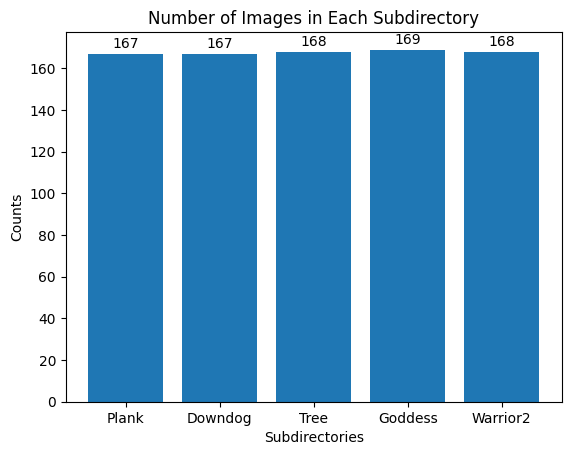

In [ ]:
path = Path(config.TRAIN_DIR)

# Get a list of all subdirectories in the root directory
subdirs = [d for d in path.iterdir() if d.is_dir()]

# Initialize a dictionary to store the count of images in each subdirectory
image_count = {}

# Iterate through each subdirectory
for subdir in subdirs:
    subdir_images = list(sorted(paths.list_images(subdir)))
    image_count[subdir.name] = len(subdir_images)

plt.bar(image_count.keys(), image_count.values())
# add the count numbers on top of the bars
for i, (subdir, count) in enumerate(image_count.items()):
    plt.text(i, count + 3, str(count), ha='center')

# set the title and labels for the plot
plt.title("Number of Images in Each Subdirectory")
plt.xlabel("Subdirectories")
plt.ylabel("Counts")

# show the plot
plt.show()

In [ ]:
# Initialize Augmentations

# initialize our data augmentation functions
resize = transforms.Resize(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
make_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
center_cropper = transforms.CenterCrop((config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.5)
random_rotation = transforms.RandomRotation(degrees=180)
random_crop = transforms.RandomCrop(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_erasing = transforms.RandomErasing()
# randomly_choose_one

# initialize our training and validation set data augmentation pipeline
train_transforms = transforms.Compose([
  resize,
  center_cropper,
  random_crop,
  random_horizontal_flip,
  random_vertical_flip,
  random_rotation,
  make_tensor,
  normalize
])

val_transforms = transforms.Compose([resize, make_tensor, normalize])

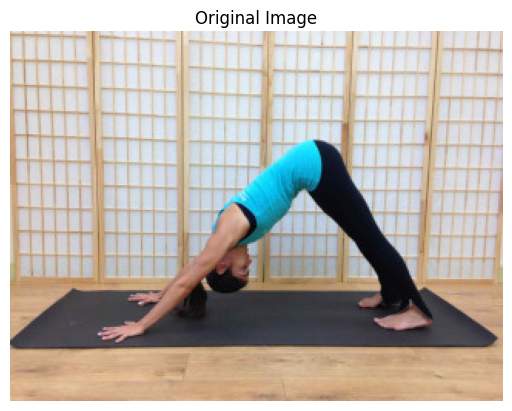

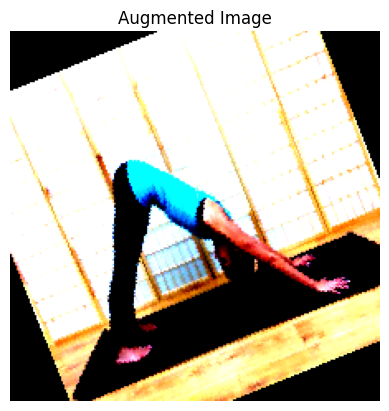

In [ ]:
# Examine what a single image looks like after the augmentation pipeline

img = Image.open(train_image_path_sample[0])

plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

img_tensor = train_transforms(img)
img_tensor = img_tensor.numpy().transpose((1, 2, 0))
img_tensor = np.clip(img_tensor, 0, 1)

plt.imshow(img_tensor)
plt.axis("off")
plt.title("Augmented Image")
plt.show()

In [ ]:
# Instantiate DataLoaders

def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    val_transform:  transforms.Compose,
    test_transform:  transforms.Compose,
    batch_size: int,
    num_workers: int=2
):
  """Creates training and validation DataLoaders.
  Args:
    train_dir: Path to training data.
    val_dir: Path to validation data.
    transform: Transformation pipeline.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, val_dataloader, class_names).
  """
  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  val_data = datasets.ImageFolder(val_dir, transform=val_transform)
  test_data = datasets.ImageFolder(test_dir, transform=val_transform)

  print(f"[INFO] training dataset contains {len(train_data)} samples...")
  print(f"[INFO] validation dataset contains {len(val_data)} samples...")
  print(f"[INFO] test dataset contains {len(test_data)} samples...")
    # Get class names
  class_names = train_data.classes
  print(f"[INFO] dataset contains {len(class_names)} labels...")

  # Turn images into data loaders
  print("[INFO] creating training and validation set dataloaders...")
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      drop_last=True,
      num_workers=num_workers,
      pin_memory=True,
      persistent_workers=True
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=config.TRAIN_DIR,
                                                                     val_dir=config.TEST_DIR,
                                                                     test_dir=config.TEST_DIR,
                                                                     train_transform=train_transforms,
                                                                     val_transform=val_transforms,
                                                                     test_transform=val_transforms,
                                                                     batch_size=16)

NUM_CLASSES = len(class_names)

[INFO] training dataset contains 839 samples...
[INFO] validation dataset contains 149 samples...
[INFO] test dataset contains 149 samples...
[INFO] dataset contains 5 labels...
[INFO] creating training and validation set dataloaders...


In [ ]:
# Get the training recipe and instantiate the SuperGradients trainer

efficientnet_training_params =  training_hyperparams.get('training_hyperparams/imagenet_efficientnet_train_params')

/usr/local/lib/python3.9/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/imagenet_efficientnet_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [ ]:
efficientnet_training_params

{'resume': False,
 'resume_path': None,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'step',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 3,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 0,
 'warmup_initial_lr': 1e-06,
 'step_lr_update_freq': 2.4,
 'cosine_final_lr_ratio': 0.01,
 'warmup_mode': 'linear_epoch_step',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'RMSpropTF',
 'optimizer_params': {'momentum': 0.9, 'weight_decay': 1e-05, 'eps': 0.001},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': True,
 'loss': 'cross_entropy',
 'criterion_params': {'smooth_eps': 0.1},
 'ema': True,
 'ema_params': {'decay': 0.9999, 'decay_type': 'constant', 'beta': 15},
 'train_metrics_list': ['Accuracy', 'Top5'],
 'valid_metrics_list': ['Accuracy', 'Top5'],
 'metric_to_watch': 'Accuracy',
 'greater_metric_to_watch_is_better': True,
 'launch_tensorboard': False,
 'tensorboard_port': None,
 'tb_files_user_prompt': False,
 'save_tensorboard_to_s3': False,
 'preci

In [ ]:
# To reduce clutter in the notebook I've turned the verbosity off, you can turn it on to see the full output
early_stop_acc = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="Accuracy", mode="max", patience=20, verbose=False)
early_stop_val_loss = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="LabelSmoothingCrossEntropyLoss", mode="min", patience=20, verbose=False)

efficientnet_training_params["train_metrics_list"] = [Accuracy()]
efficientnet_training_params["valid_metrics_list"] = [Accuracy()]
efficientnet_training_params["phase_callbacks"] = [early_stop_acc, early_stop_val_loss]

# Set the silent mode to True to reduce clutter in the notebook, you can turn it on to see the full output
efficientnet_training_params["silent_mode"] = True
# We'll turn off the use of exponential moving average and zero weight decay on bias and batch norm
efficientnet_training_params['ema'] = False
efficientnet_training_params['zero_weight_decay_on_bias_and_bn'] = False

In [ ]:
efficientnet_training_params["criterion_params"] = {'smooth_eps': 0.25}
efficientnet_training_params["max_epochs"] = 200
efficientnet_training_params["initial_lr"] = 0.0001

In [ ]:
efficientnet_full_model = models.get(model_name='efficientnet_b0', num_classes= len(class_names), pretrained_weights='imagenet')
full_model_trainer = Trainer(experiment_name="0_Baseline_Experiment", ckpt_root_dir='checkpoints')

full_model_trainer.train(model=efficientnet_full_model,
              training_params=efficientnet_training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)


NOTICE: 
achieving EfficientNet's reported accuracy requires specific image resolution.
Please verify image size is 224x224 for this specific EfficientNet configuration



Downloading: "https://deci-pretrained-models.s3.amazonaws.com/efficientnet_b0/average_model-3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_average_model-3.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

The console stream is now moved to checkpoints/0_Baseline_Experiment/console_Apr16_00_33_49.txt


[2023-04-16 00:33:52] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 839        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         52         (len(train_set) / total_batch_size)
    - Gradient updates per epoch:   52         (len(train_set) / effective_batch_size)

/usr/local/lib/python3.9/dist-packages/super_gradients/training/utils/optimizers/rmsprop_tf.py:109: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggere

In [ ]:
# Load the best model that we trained
best_full_model = models.get('efficientnet_b0',
                        num_classes=len(class_names),
                        checkpoint_path=os.path.join(full_model_trainer.checkpoints_dir_path, "ckpt_best.pth"))


NOTICE: 
achieving EfficientNet's reported accuracy requires specific image resolution.
Please verify image size is 224x224 for this specific EfficientNet configuration



[2023-04-16 00:41:33] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/0_Baseline_Experiment/ckpt_best.pth checkpoint.


In [ ]:
full_model_trainer.test(model=best_full_model,
            test_loader=test_dataloader,
            test_metrics_list=['Accuracy'])

Test:  40%|████      | 4/10 [00:00<00:00,  9.92it/s]

(0.85193634, tensor(0.9933, device='cuda:0'))

Test: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s]


In [ ]:
import requests
def pred_and_plot_image(image_path: str,
                        subplot: Tuple[int, int, int],  # subplot tuple for `subplot()` function
                        class_names: List[str] = class_names,
                        model: torch.nn.Module = best_full_model,
                        image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
                        transform: torchvision.transforms = None,
                        device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
        img = Image.open(image_path)
    else:
        img = Image.open(requests.get(image_path, stream=True).raw)

    # create transformation for image (if one doesn't exist)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    transformed_image = transform(img)
        # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = transformed_image.unsqueeze(dim=0)

        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # actual label
    ground_truth = PurePath(image_path).parent.name
    # plot image with predicted label and probability
    plt.subplot(*subplot)
    plt.imshow(img)
    if isinstance(image_path, pathlib.PosixPath):
        title = f"Ground Truth: {ground_truth} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title("\n".join(textwrap.wrap(title, width=20)))  # wrap text using textwrap.wrap() function
    plt.axis(False)
def plot_random_test_images(model):
    num_images_to_plot = 30
    test_image_path_list = list(Path(config.TEST_DIR).glob("*/*.jpg")) # get list all image paths from test data
    test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                           k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

    # set up subplots
    num_rows = int(np.ceil(num_images_to_plot / 5))
    fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    ax = ax.flatten()
    # Make predictions on and plot the images
    for i, image_path in enumerate(test_image_path_sample):
        pred_and_plot_image(model=model,
                            image_path=image_path,
                            class_names=class_names,
                            subplot=(num_rows, 5, i+1),  # subplot tuple for `subplot()` function
                            image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH))

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=1)
    plt.show()

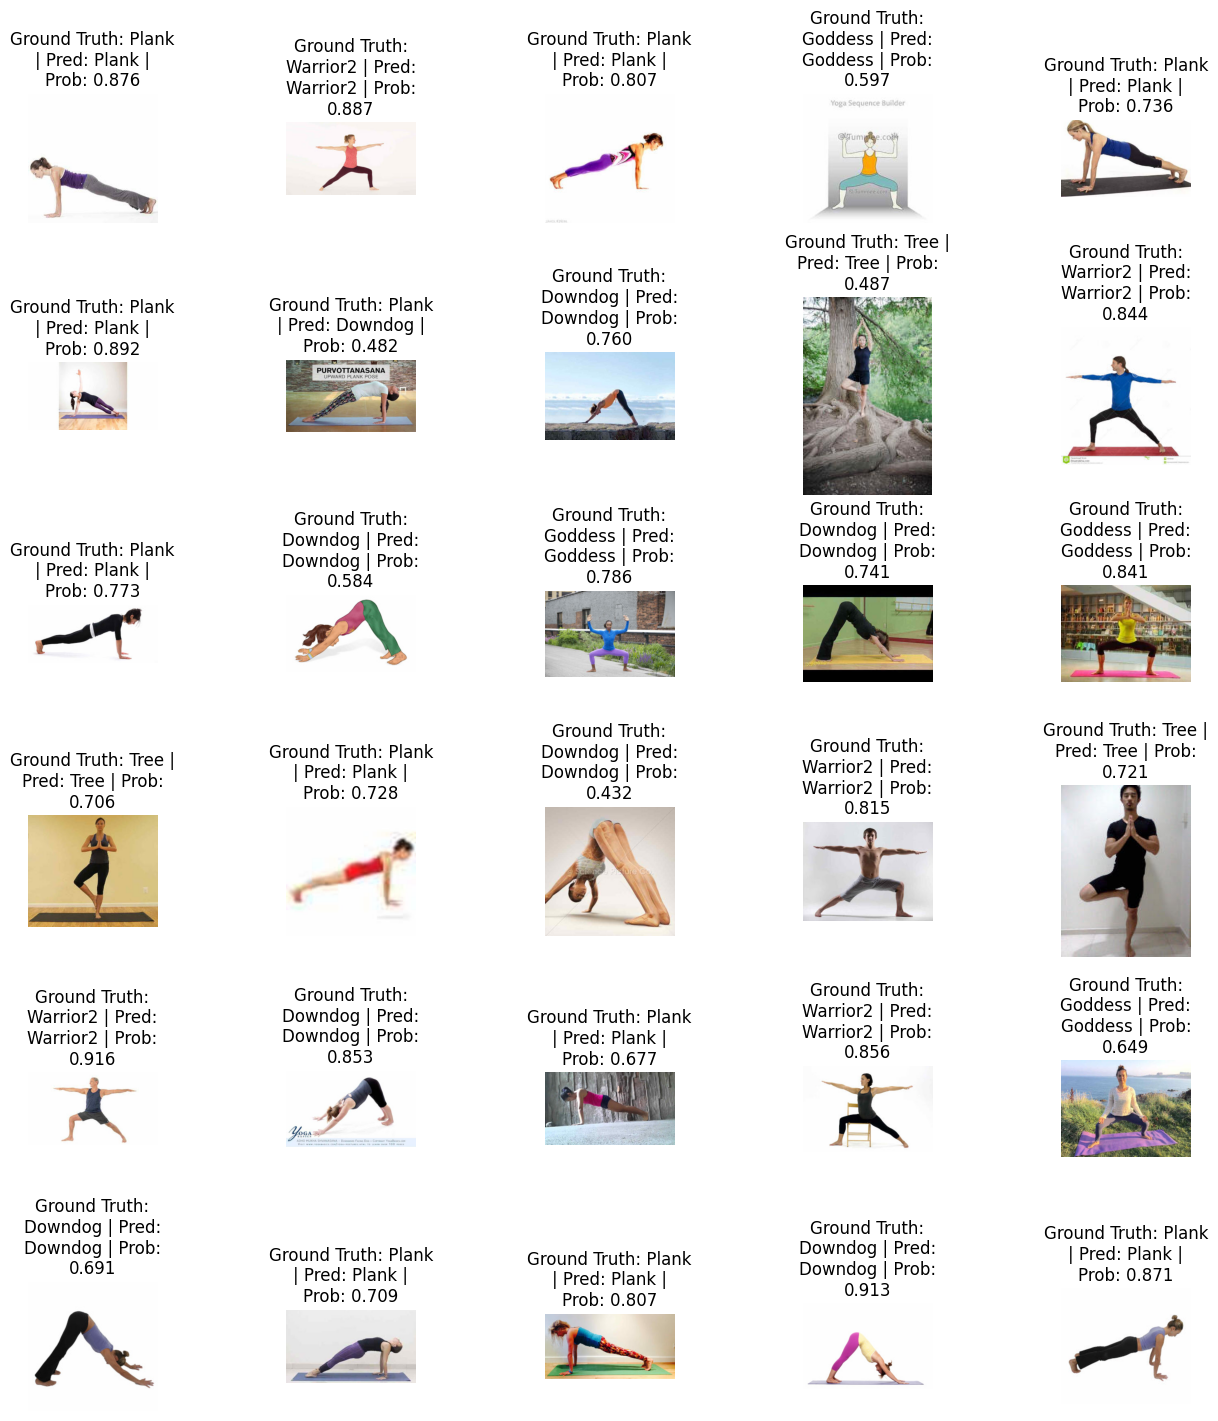

In [ ]:
plot_random_test_images(best_full_model)

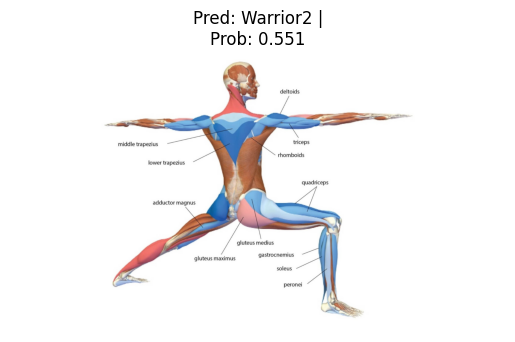

In [ ]:
pred_and_plot_image(image_path='https://www.yogajournal.com/wp-content/uploads/2021/07/Warrior-I-Pose-Virabhadrasana-II-1.jpg', subplot=(1, 1, 1))

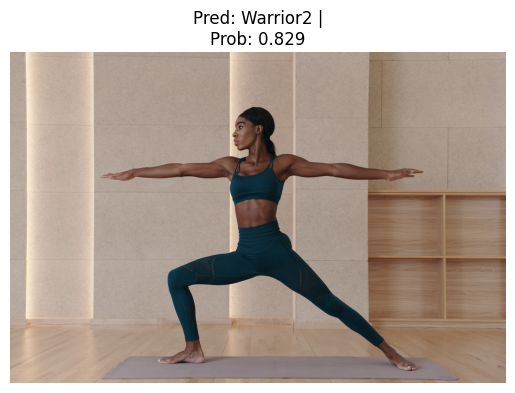

In [ ]:
pred_and_plot_image(image_path='https://images.ctfassets.net/3s5io6mnxfqz/5p1o5aDy0gthIFdGquvAzM/e70b350d1f675ce8bb2e0a6e1aa5f576/AdobeStock_360772900.jpeg', subplot=(1, 1, 1))

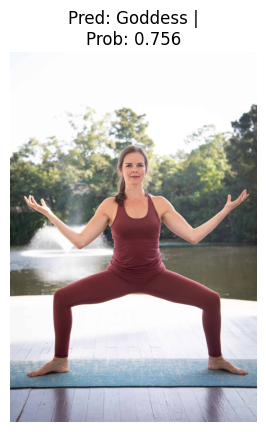

In [ ]:
pred_and_plot_image(image_path='https://beextrayoga.com/wp-content/uploads/2019/11/Nicole_202-Goddess-Pose-scaled.jpg', subplot=(1, 1, 1))

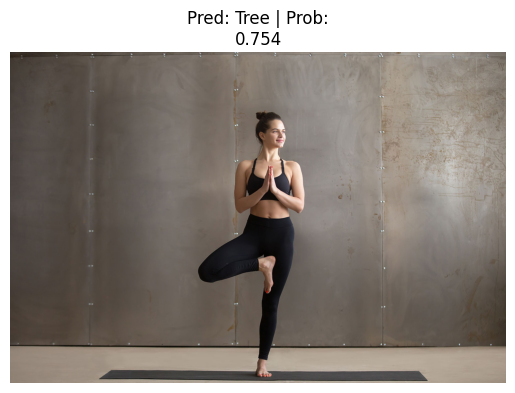

In [ ]:
pred_and_plot_image(image_path='https://yogapractice.com/wp-content/uploads/2019/05/How-to-Do-Tree-Pose-1.jpg', subplot=(1, 1, 1))